In [1]:
import os
from pathlib import Path
from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from omegaconf import OmegaConf
import masknmf

No windowing system present. Using surfaceless platform
No config found!
No config found!
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),Quadro RTX 8000,DiscreteGPU,Vulkan,565.57.01
✅,Quadro RTX 8000,DiscreteGPU,Vulkan,565.57.01
❌,Quadro RTX 8000/PCIe/SSE2,Unknown,OpenGL,3.3.0 NVIDIA 565.57.01


Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


In [2]:
class MaskedConv2d(nn.Conv2d):
    """Conv2d with the center pixel masked to prevent information leakage."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        mask = torch.ones_like(self.weight)
        kH, kW = self.weight.shape[-2:]
        mask[:, :, kH // 2, kW // 2] = 0.0
        self.register_buffer("mask", mask)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.conv2d(
            x, self.weight * self.mask, self.bias,
            self.stride, self.padding, self.dilation, self.groups
        )


class ConvBlock2d(nn.Module):
    """Convolution block with LeakyReLU activation."""
    def __init__(self, in_ch: int, out_ch: int, kernel_size: int = 3,
                 dilation: int = 1, use_mask: bool = False):
        super().__init__()
        # Use 'same' style padding for odd kernels:
        padding = dilation * (kernel_size // 2)
        ConvClass = MaskedConv2d if use_mask else nn.Conv2d
        self.conv = ConvClass(in_ch, out_ch, kernel_size,
                              dilation=dilation, padding=padding)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.conv(x))


class BlindSpotSpatial(nn.Module):
    """Blind-spot network backbone that never sees the center pixel."""
    def __init__(self, out_channels: int = 1, final_activation: Optional[nn.Module] = None):
        super().__init__()
        self.reg_conv1 = ConvBlock2d(1, 16, kernel_size=3, dilation=1, use_mask=False)
        self.reg_conv2 = ConvBlock2d(16, 32, kernel_size=3, dilation=1, use_mask=False)
        self.reg_conv3 = ConvBlock2d(32, 48, kernel_size=3, dilation=1, use_mask=False)
        self.reg_conv4 = ConvBlock2d(48, 64, kernel_size=3, dilation=1, use_mask=False)
        self.reg_conv5 = ConvBlock2d(64, 80, kernel_size=3, dilation=1, use_mask=False)

        self.bsconv1 = ConvBlock2d(1, 16, kernel_size=3, dilation=1, use_mask=True)
        self.bsconv2 = ConvBlock2d(16, 32, kernel_size=3, dilation=2, use_mask=True)
        self.bsconv3 = ConvBlock2d(32, 48, kernel_size=3, dilation=3, use_mask=True)
        self.bsconv4 = ConvBlock2d(48, 64, kernel_size=3, dilation=4, use_mask=True)
        self.bsconv5 = ConvBlock2d(64, 80, kernel_size=3, dilation=5, use_mask=True)
        self.bsconv6 = ConvBlock2d(80, 96, kernel_size=3, dilation=6, use_mask=True)

        self.final = nn.Conv2d(16 + 32 + 48 + 64 + 80 + 96, out_channels, kernel_size=1)
        self.final_activation = final_activation or nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Regular encodings
        enc1 = self.reg_conv1(x)
        enc2 = self.reg_conv2(enc1)
        enc3 = self.reg_conv3(enc2)
        enc4 = self.reg_conv4(enc3)
        enc5 = self.reg_conv5(enc4)

        # Blind-spot convolutions
        bs1 = self.bsconv1(x)
        bs2 = self.bsconv2(enc1)
        bs3 = self.bsconv3(enc2)
        bs4 = self.bsconv4(enc3)
        bs5 = self.bsconv5(enc4)
        bs6 = self.bsconv6(enc5)

        out = torch.cat([bs1, bs2, bs3, bs4, bs5, bs6], dim=1)
        return self.final_activation(self.final(out))


class SpatialNetwork(nn.Module):
    """Predicts the mean and total variance for denoising."""
    def __init__(self):
        super().__init__()
        self.mean_backbone = BlindSpotSpatial(out_channels=1, final_activation=None)
        self.var_backbone = BlindSpotSpatial(out_channels=1, final_activation=nn.Softplus())

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.mean_backbone(x), self.var_backbone(x)


class TotalVarianceSpatialDenoiser(pl.LightningModule):
    """PyTorch Lightning module for training the spatial denoiser."""
    def __init__(self, learning_rate: float = 1e-3, max_epochs: int = 1):
        super().__init__()
        self.spatial_network = SpatialNetwork()
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.spatial_network(x)

    def training_step(self, batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
        mu_x, total_variance = self(batch)
        total_variance = torch.clamp(total_variance, min=1e-8)
        log_lik = torch.nansum(torch.log(total_variance))
        log_lik += torch.nansum((batch - mu_x) ** 2 / total_variance)
        loss = log_lik / batch.numel()
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [3]:
class PMDSpatialDenoiser(nn.Module):
    """
    Wrapper that adapts the trained spatial denoiser for PMD usage.

    The wrapper:
      - Estimates a noise variance per spatial component (via quantile of predicted total variance)
      - Denoises each spatial component using the trained blind-spot network.
    """
    def __init__(self,
                 trained_model: TotalVarianceSpatialDenoiser,
                 noise_variance_quantile: float = 0.05,
                 padding: int = 16):
        super().__init__()
        self.net = trained_model.spatial_network
        self.noise_variance_quantile = noise_variance_quantile
        self._padding = padding

    def _estimate_noise_variance(self, spatial_basis: torch.Tensor) -> torch.Tensor:
        """
        Estimate an independent noise variance for each spatial component.

        Args:
            spatial_basis: Tensor of shape (H, W, num_components)

        Returns:
            Tensor of shape (num_components,) with the estimated noise variance for each component.
        """
        H, W, num_comp = spatial_basis.shape
        device = spatial_basis.device
        noise_vars = torch.zeros(num_comp, device=device)

        with torch.no_grad():
            for idx in range(num_comp):
                comp = spatial_basis[:, :, idx]

                # Normalize to match denoiser preprocessing
                comp_mean = comp.mean()
                comp_centered = comp - comp_mean
                comp_norm = torch.clamp(torch.linalg.norm(comp_centered), min=1e-6)
                comp_normalized = comp_centered / comp_norm

                # Add padding (reflect)
                if self._padding > 0:
                    comp_input = F.pad(
                        comp_normalized.unsqueeze(0).unsqueeze(0),
                        (self._padding,) * 4,
                        mode='reflect'
                    )
                else:
                    comp_input = comp_normalized.unsqueeze(0).unsqueeze(0)

                # Predict total variance
                _, total_var = self.net(comp_input)

                # Remove padding if present and compute quantile
                if self._padding > 0:
                    p = self._padding
                    total_var_center = total_var[:, :, p:-p, p:-p]
                else:
                    total_var_center = total_var

                noise_vars[idx] = torch.quantile(
                    total_var_center.flatten(),
                    self.noise_variance_quantile
                )

        return noise_vars

    def _denoise_single_component(self,
                                  component: torch.Tensor,
                                  component_idx: int,
                                  noise_variance: torch.Tensor) -> torch.Tensor:
        """
        Denoise a single spatial component.

        Args:
            component: Tensor (H, W)
            component_idx: index of component
            noise_variance: Tensor of shape (num_components,) or (1,)

        Returns:
            Denoised component (H, W)
        """
        # Normalize
        comp_mean = component.mean()
        comp_centered = component - comp_mean
        comp_norm = torch.clamp(torch.linalg.norm(comp_centered), min=1e-6)
        comp_normalized = comp_centered / comp_norm

        # Add padding
        if self._padding > 0:
            comp_padded = F.pad(
                comp_normalized.unsqueeze(0).unsqueeze(0),
                (self._padding,) * 4,
                mode='reflect'
            )
        else:
            comp_padded = comp_normalized.unsqueeze(0).unsqueeze(0)

        with torch.no_grad():
            mu_x, total_var = self.net(comp_padded)

            # Variance partitioning: ensure total_var >= noise_var
            noise_var = noise_variance[component_idx].view(1, 1, 1, 1)
            total_var_clamped = torch.clamp(total_var, min=noise_var)
            signal_var = torch.clamp(total_var_clamped - noise_var, min=0.0)

            # Bayesian-style weights
            weight_signal = noise_var / total_var_clamped
            weight_observation = signal_var / total_var_clamped

            # Weighted combination (denoised)
            denoised_normalized = weight_signal * mu_x + weight_observation * comp_padded

        # Remove padding if added
        if self._padding > 0:
            p = self._padding
            denoised_normalized = denoised_normalized[:, :, p:-p, p:-p]

        # Denormalize back to original scale
        denoised = denoised_normalized.squeeze(0).squeeze(0) * comp_norm + comp_mean
        return denoised

    def forward(self, spatial_basis: torch.Tensor) -> torch.Tensor:
        """
        Denoise all spatial components.

        Args:
            spatial_basis: Tensor with shape (H, W, num_components)

        Returns:
            Tensor with shape (H, W, num_components) of denoised components.
        """
        H, W, num_comp = spatial_basis.shape

        # Always estimate noise variance per-call / per-block
        noise_variance = self._estimate_noise_variance(spatial_basis)

        denoised_components = []
        for i in range(num_comp):
            comp = spatial_basis[:, :, i]
            denoised_comp = self._denoise_single_component(comp, i, noise_variance)
            denoised_components.append(denoised_comp)

        return torch.stack(denoised_components, dim=2)


In [4]:
class MultivariateImagePatchDataset(Dataset):
    """
    Extract overlapping patches from 2D images with normalization.

    Memory-optimized: stores only indices and computes patches on-the-fly.
    """

    def __init__(self, data: torch.Tensor, patch_size: Tuple[int, int] = (128, 128),
                 overlap: int = 32, padding: int = 0, provide_indices: bool = False):
        # Ensure shape is [N, C, H, W]
        if data.ndim == 3:
            data = data[:, None, :, :]  # [N, 1, H, W]

        # Keep data on CPU to save GPU memory
        self.data = data.float().cpu()
        self.padding = padding

        # Apply reflect padding if requested
        if padding > 0:
            self.data = F.pad(self.data, (padding, ) * 4, mode='reflect')

        self.N, self.C, self.H, self.W = self.data.shape
        self.ph, self.pw = patch_size
        self.provide_indices = provide_indices

        # Compute patch start positions with requested overlap
        stride_h = max(1, self.ph - overlap)
        stride_w = max(1, self.pw - overlap)

        ys = list(range(0, self.H - self.ph + 1, stride_h))
        if not ys or ys[-1] != self.H - self.ph:
            ys.append(max(0, self.H - self.ph))

        xs = list(range(0, self.W - self.pw + 1, stride_w))
        if not xs or xs[-1] != self.W - self.pw:
            xs.append(max(0, self.W - self.pw))

        # Filter out constant images to avoid degenerate patches
        stds = self.data.view(self.N, -1).std(dim=1)
        non_const = stds > 1e-6
        if non_const.sum() < self.N:
            self.data = self.data[non_const]
            self.N = self.data.shape[0]

        # Store only start indices (n, sy, sx)
        self.starts = [(n, sy, sx) for n in range(self.N) for sy in ys for sx in xs]

        # Compute per-image normalization stats
        self.means = self.data.mean(dim=(2, 3), keepdim=True)  # [N, C, 1, 1]
        norms = torch.linalg.norm((self.data - self.means).view(self.N, -1), dim=1, keepdim=True).view(self.N, 1, 1, 1)
        norms[norms == 0] = 1.0
        self.norms = norms

        print(f"Dataset created: {len(self.starts)} patches from {self.N} images")
        print(f"Memory footprint: {self.data.element_size() * self.data.nelement() / 1024**3:.2f} GB")

    def __len__(self) -> int:
        return len(self.starts)

    def __getitem__(self, idx: int):
        n, sy, sx = self.starts[idx]
        # Extract patch on-the-fly
        patch = self.data[n:n+1, :, sy:sy+self.ph, sx:sx+self.pw]
        # Normalize on-the-fly
        patch = (patch - self.means[n:n+1]) / self.norms[n:n+1]
        patch = patch.squeeze(0)  # Remove batch dimension

        if self.provide_indices:
            return patch, n, sy, sx
        return patch


class MotionBinDataset:
    """Load a memmapped suite2p data.bin together with metadata (.npy/.zip)."""
    def __init__(self, data_path: str, metadata_path: str, dtype=np.int16):
        self.bin_path = Path(data_path)
        self.ops_path = Path(metadata_path)
        self._dtype = dtype
        self._shape = self._compute_shape()
        # Memory-map the binary file
        self.data = np.memmap(self.bin_path, mode='r', dtype=self._dtype, shape=self._shape)

    def _compute_shape(self) -> Tuple[int, int, int]:
        _, ext = os.path.splitext(self.ops_path)
        if ext == ".zip":
            ops = np.load(self.ops_path, allow_pickle=True)['ops'].item()
        elif ext == ".npy":
            ops = np.load(self.ops_path, allow_pickle=True).item()
        else:
            raise ValueError("Metadata file must be .zip or .npy")
        return int(ops['nframes']), int(ops['Ly']), int(ops['Lx'])

    @property
    def shape(self) -> Tuple[int, int, int]:
        return self._shape

    def __getitem__(self, item):
        return self.data[item].copy()



In [5]:
def test_blindspot_leakage_2d(model: nn.Module, H: int = 64, W: int = 64, device: str = 'cpu') -> float:
    """
    Test that the model's blind-spot property prevents center-pixel leakage.
    Returns the maximum absolute difference at the center pixel for two inputs
    that differ only at the center pixel.
    """
    model.eval()
    with torch.no_grad():
        base = torch.randn(1, 1, H, W)
        img1, img2 = base.clone(), base.clone()
        cy, cx = H // 2, W // 2

        img1[0, 0, cy, cx] = 0.0
        img2[0, 0, cy, cx] = 100.0

        out1_mu, _ = model(img1.to(device))
        out2_mu, _ = model(img2.to(device))

        diff = (out1_mu[..., cy, cx] - out2_mu[..., cy, cx]).abs().max().item()
        return diff


In [6]:
config = {
    'bin_file_path': '/burg-archive/home/lm3879/plane4/data.bin',
    'ops_file_path': '/burg-archive/home/lm3879/plane4/ops.npy',
    'out_path': '/burg-archive/home/lm3879/masknmf-toolbox/ibl_denoised_output/pmd_spatial_results.npz',
    'block_size_dim1': 20,
    'block_size_dim2': 20,
    'max_components': 20,
    'max_consecutive_failures': 1,
    'spatial_avg_factor': 1,
    'temporal_avg_factor': 1,
    'device': 'cuda',
    'frame_batch_size': 1024,
    'denoiser_max_epochs': 1,
    'denoiser_batch_size': 32,  # reduced from 64 to save memory
    'denoiser_lr': 1e-4,
    'patch_h': 64,
    'patch_w': 64,
    'patch_overlap': 32,  # increased overlap
    'patch_padding': 0,
    'train_patch_subset': 500000,  # limit training patches
    'num_workers': 4,  # reduced from 6 to save memory
    'gradient_accumulation_steps': 2,  # simulate larger batch
}

cfg = OmegaConf.create(config)
device = cfg.device if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


Using device: cuda
GPU: Quadro RTX 8000
Total memory: 44.30 GB


In [7]:
my_data = MotionBinDataset(cfg.bin_file_path, cfg.ops_file_path)
print(f"Loaded data with shape (T,H,W): {my_data.shape}")

# Build binary mask for PMD (mask out 3 pixels border)
binary_mask = np.zeros((my_data.shape[1], my_data.shape[2]), dtype=np.float32)
binary_mask[3:-3, 3:-3] = 1.0

# Run PMD decomposition without spatial denoiser
pmd_no_denoise = masknmf.compression.pmd_decomposition(
    my_data,
    [cfg.block_size_dim1, cfg.block_size_dim2],
    my_data.shape[0],
    max_components=cfg.max_components,
    max_consecutive_failures=cfg.max_consecutive_failures,
    temporal_avg_factor=cfg.temporal_avg_factor,
    spatial_avg_factor=cfg.spatial_avg_factor,
    device=cfg.device,
    temporal_denoiser=None,
    frame_batch_size=cfg.frame_batch_size,
    pixel_weighting=binary_mask
)
print(f"PMD rank: {pmd_no_denoise.pmd_rank}")



Loaded data with shape (T,H,W): (11700, 500, 620)
[25-11-29 00:59:32]: Starting compression
[25-11-29 00:59:32]: sampled from the following regions: [0]
[25-11-29 00:59:32]: We are initializing on a total of 11700 frames
[25-11-29 01:03:06]: Loading data to estimate complete spatial basis
[25-11-29 01:03:06]: skipping the pruning step for frame cutoff
[25-11-29 01:03:06]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:04<00:00, 56.53it/s] 

[25-11-29 01:03:10]: Running Blockwise Decompositions


[25-11-29 01:04:34]: Constructed U matrix. Rank of U is 6234
[25-11-29 01:04:35]: PMD Objected constructed
PMD rank: 6234


In [8]:
print("=" * 60)
print("Extracting spatial components from PMD results...")
print("=" * 60)

# Convert sparse/dense U to (H, W, rank) on CPU
u_dense = pmd_no_denoise.u.to_dense().cpu()  # shape: (H*W, rank)
H, W = my_data.shape[1], my_data.shape[2]
u_reshaped = u_dense.reshape(H, W, -1)  # (H, W, rank)

print(f"Spatial components shape: {u_reshaped.shape}")
print(f"Number of components: {u_reshaped.shape[2]}")

# Convert to (rank, H, W) for dataset consumption
spatial_components = u_reshaped.permute(2, 0, 1)  # (rank, H, W)

print(f"Spatial components for training shape: {spatial_components.shape}")
print(f"Memory footprint: {spatial_components.element_size() * spatial_components.nelement() / 1024**3:.2f} GB")


Extracting spatial components from PMD results...
Spatial components shape: torch.Size([500, 620, 6234])
Number of components: 6234
Spatial components for training shape: torch.Size([6234, 500, 620])
Memory footprint: 7.20 GB


In [9]:
print("=" * 60)
print("Creating patch dataset from spatial components...")
print("=" * 60)

# Build patch dataset (data stays on CPU)
dataset = MultivariateImagePatchDataset(
    spatial_components,
    patch_size=(cfg.patch_h, cfg.patch_w),
    overlap=cfg.patch_overlap,
    padding=cfg.patch_padding,
    provide_indices=False
)

# Optionally use a random subset of patches for training
if cfg.train_patch_subset is not None:
    subset_n = min(int(cfg.train_patch_subset), len(dataset))
    indices = torch.randperm(len(dataset))[:subset_n].tolist()
    dataset = torch.utils.data.Subset(dataset, indices)
    print(f"Using {subset_n} random patches for training")

# DataLoader with pin_memory for faster CPU->GPU transfers
train_loader = DataLoader(
    dataset,
    batch_size=cfg.denoiser_batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=True,
    persistent_workers=True if cfg.num_workers > 0 else False,
)
print(f"DataLoader ready with {len(train_loader)} batches")

# Clear cached GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


Creating patch dataset from spatial components...
Dataset created: 1776690 patches from 6234 images
Memory footprint: 7.20 GB
Using 500000 random patches for training
DataLoader ready with 15625 batches
GPU memory allocated: 0.01 GB
GPU memory cached: 0.02 GB


In [10]:
model = TotalVarianceSpatialDenoiser(learning_rate=cfg.denoiser_lr, max_epochs=cfg.denoiser_max_epochs)
print("Initialized new model")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Trainer setup with memory-oriented options
logger = TensorBoardLogger("lightning_logs", name="total_variance_spatial")
trainer = pl.Trainer(
    max_epochs=cfg.denoiser_max_epochs,
    log_every_n_steps=10,
    devices=1,
    accelerator="gpu" if device == "cuda" else "cpu",
    precision="16-mixed" if device == "cuda" else 32,
    logger=logger,
    gradient_clip_val=1.0,
    accumulate_grad_batches=cfg.get('gradient_accumulation_steps', 1),
    enable_checkpointing=True,
    enable_progress_bar=True,
    enable_model_summary=True,
)

print("Starting training...")
print(f"Effective batch size: {cfg.denoiser_batch_size * cfg.get('gradient_accumulation_steps', 1)}")

try:
    trainer.fit(model, train_loader)
    print("Training complete!")
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print("OOM Error!")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    raise

# Report peak GPU memory if using CUDA
if torch.cuda.is_available():
    print(f"\nPeak GPU memory: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")
    torch.cuda.reset_peak_memory_stats()


Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Initialized new model
Starting training...
Effective batch size: 64


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/burg-archive/home/lm3879/miniconda3/envs/py311v2/lib/python3.11/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | spatial_network | SpatialNetwork | 509 K  | train
-----------------------------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Training complete!

Peak GPU memory: 0.76 GB


In [11]:
# Save the trained model state dict
out_dir = Path(cfg.out_path).parent
out_dir.mkdir(parents=True, exist_ok=True)
model_path = out_dir / "spatial_denoiser_state_dict.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

# Move model to device and test blind-spot leakage
model.to(device)
leak_diff = test_blindspot_leakage_2d(model.spatial_network, H=64, W=64, device=device)
print(f"Blindspot leakage test: {leak_diff:.2e}")
if leak_diff > 1e-6:
    print("WARNING: Potential information leakage detected!")
else:
    print("Blindspot property verified")

# Create PMD-compatible spatial denoiser
print("\nCreating PMD-compatible spatial denoiser...")
pmd_spatial_denoiser = PMDSpatialDenoiser(
    trained_model=model,
    noise_variance_quantile=0.7,  # set to match temporal if desired
    padding=16  # spatial padding (smaller than temporal padding typically)
)
pmd_spatial_denoiser.to(device)
pmd_spatial_denoiser.eval()
print("Spatial denoiser ready for PMD")

if torch.cuda.is_available():
    torch.cuda.empty_cache()


Model saved to: /burg-archive/home/lm3879/masknmf-toolbox/ibl_denoised_output/spatial_denoiser_state_dict.pth
Blindspot leakage test: 0.00e+00
Blindspot property verified

Creating PMD-compatible spatial denoiser...
Spatial denoiser ready for PMD


In [12]:
def test_denoising_strength_on_spatial_components(model: nn.Module,
                                                  spatial_components: torch.Tensor,
                                                  quantile: float = 0.7,
                                                  num_samples: int = 5):
    """
    Diagnostic: evaluate denoising strength for randomly chosen spatial components.
    Prints total-variance statistics and a noise estimate per component.
    """
    device = next(model.parameters()).device
    num_comp = spatial_components.shape[0]

    # Randomly choose components to inspect
    test_indices = np.random.choice(num_comp, min(num_samples, num_comp), replace=False)

    print("\n" + "=" * 60)
    print("Denoising Strength Diagnostic")
    print("=" * 60)

    for idx in test_indices:
        comp = spatial_components[idx].to(device)  # (H, W)

        # Normalize
        comp_mean = comp.mean()
        comp_std = comp.std()
        comp_norm = (comp - comp_mean) / comp_std if comp_std > 1e-6 else comp - comp_mean

        # Predict total variance
        comp_input = comp_norm.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
        with torch.no_grad():
            _, total_var = model(comp_input)

        var_values = total_var.squeeze().cpu().numpy()
        noise_est = np.quantile(var_values, quantile)

        print(f"\nComponent {idx}:")
        print(f"  Total var range: [{var_values.min():.4f}, {var_values.max():.4f}]")
        print(f"  Mean total var:  {var_values.mean():.4f}")
        print(f"  Noise estimate (q={quantile}): {noise_est:.4f}")
        print(f"  Signal ratio: {(var_values.mean() - noise_est) / var_values.mean():.2%}")

    print("=" * 60 + "\n")


# Run diagnostic
test_denoising_strength_on_spatial_components(
    model.spatial_network,
    spatial_components,
    quantile=0.7,
    num_samples=5
)



Denoising Strength Diagnostic

Component 5396:
  Total var range: [8.1940, 2992.1340]
  Mean total var:  43.3634
  Noise estimate (q=0.7): 42.0295
  Signal ratio: 3.08%

Component 3156:
  Total var range: [0.0000, 55842.9062]
  Mean total var:  61.3549
  Noise estimate (q=0.7): 0.0001
  Signal ratio: 100.00%

Component 5220:
  Total var range: [10.3202, 625.3213]
  Mean total var:  51.1437
  Noise estimate (q=0.7): 51.4767
  Signal ratio: -0.65%

Component 3895:
  Total var range: [10.0496, 740.4920]
  Mean total var:  49.9128
  Noise estimate (q=0.7): 50.2028
  Signal ratio: -0.58%

Component 4240:
  Total var range: [0.0000, 30049.3184]
  Mean total var:  25.8892
  Noise estimate (q=0.7): 0.0000
  Signal ratio: 100.00%



In [13]:
print("=" * 60)
print("Running PMD decomposition WITH spatial denoiser...")
print("=" * 60)

# Clear GPU memory if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()

pmd_with_denoise_S = masknmf.compression.pmd_decomposition(
    my_data,
    [cfg.block_size_dim1, cfg.block_size_dim2],
    my_data.shape[0],
    max_components=cfg.max_components,
    max_consecutive_failures=cfg.max_consecutive_failures,
    temporal_avg_factor=cfg.temporal_avg_factor,
    spatial_avg_factor=cfg.spatial_avg_factor,
    device=cfg.device,
    spatial_denoiser=pmd_spatial_denoiser,
    temporal_denoiser=None,
    frame_batch_size=cfg.frame_batch_size,
    pixel_weighting=binary_mask
)

# Use the CompressDenoiseStrategy as in the original script
compress_strategy = masknmf.CompressDenoiseStrategy(
    dataset=my_data,
    block_sizes=(cfg.block_size_dim1, cfg.block_size_dim2),
    noise_variance_quantile=0.7,
    num_epochs=1
)
pmd_with_denoise_T = compress_strategy.compress()

print(f"\n{'=' * 60}")
print("PMD Results:")
print(f"  Without denoiser:       rank = {pmd_no_denoise.pmd_rank}")
print(f"  With spatial denoiser:  rank = {pmd_with_denoise_S.pmd_rank}")
print(f"  With temporal denoiser: rank = {pmd_with_denoise_T.pmd_rank}")
print(f"{'=' * 60}")

Running PMD decomposition WITH spatial denoiser...
[25-11-29 01:12:35]: Starting compression
[25-11-29 01:12:35]: sampled from the following regions: [0]
[25-11-29 01:12:35]: We are initializing on a total of 11700 frames
[25-11-29 01:12:46]: Loading data to estimate complete spatial basis
[25-11-29 01:12:46]: skipping the pruning step for frame cutoff
[25-11-29 01:12:46]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:01<00:00, 143.03it/s]

[25-11-29 01:12:48]: Running Blockwise Decompositions


[25-11-29 01:17:16]: Constructed U matrix. Rank of U is 6387
[25-11-29 01:17:17]: PMD Objected constructed
[25-11-29 01:17:17]: Starting compression
[25-11-29 01:17:17]: sampled from the following regions: [0]
[25-11-29 01:17:17]: We are initializing on a total of 11700 frames
[25-11-29 01:17:27]: Loading data to estimate complete spatial basis
[25-11-29 01:17:27]: skipping the pruning step for frame cutoff
[25-11-29 01:17:27]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:00<00:00, 318.78it/s]

[25-11-29 01:17:28]: Running Blockwise Decompositions


[25-11-29 01:18:29]: Constructed U matrix. Rank of U is 6207
[25-11-29 01:18:30]: PMD Objected constructed


Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/burg-archive/home/lm3879/miniconda3/envs/py311v2/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /burg-archive/home/lm3879/masknmf-toolbox/masknmf/compression/lightning_logs/version_5019732/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params | Mode 
-------------------------------------------------------------
0 | temporal_network | TemporalNetwork | 278 K  | train
-------------------------------------------------------------
170 K     Trainable params
107 K     Non-trainable params
278 K     Total params
1.114     Total estimated mo

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


[25-11-29 01:19:19]: Starting compression
[25-11-29 01:19:19]: sampled from the following regions: [0]
[25-11-29 01:19:19]: We are initializing on a total of 11700 frames
[25-11-29 01:19:29]: Loading data to estimate complete spatial basis
[25-11-29 01:19:29]: skipping the pruning step for frame cutoff
[25-11-29 01:19:29]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:04<00:00, 60.01it/s]

[25-11-29 01:19:33]: Running Blockwise Decompositions


[25-11-29 01:27:47]: Constructed U matrix. Rank of U is 6780
[25-11-29 01:27:48]: PMD Objected constructed

PMD Results:
  Without denoiser:       rank = 6234
  With spatial denoiser:  rank = 6387
  With temporal denoiser: rank = 6780


RFBOutputContext()

Max vertex attribute stride unknown. Assuming it is 2048
/burg-archive/home/lm3879/miniconda3/envs/py311v2/lib/python3.11/site-packages/fastplotlib/graphics/features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
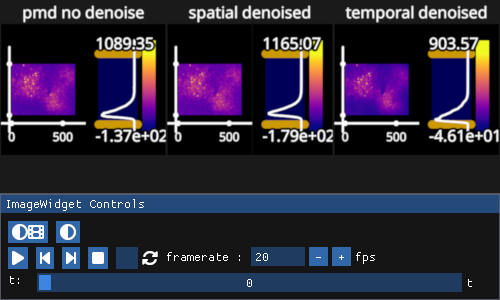

In [14]:
import fastplotlib as fpl
iw = fpl.ImageWidget(data = [pmd_no_denoise, pmd_with_denoise_S, pmd_with_denoise_T], names = ['pmd no denoise', 'spatial denoised', 'temporal denoised'],  figure_shape=(1,3))
iw.show()

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
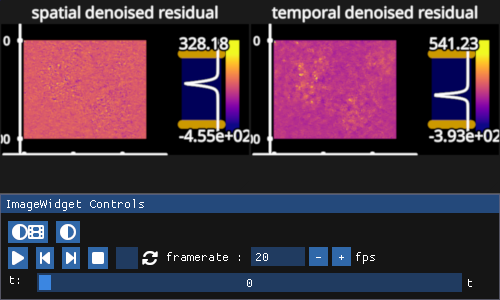

In [15]:
resid_arr_S = masknmf.compression.PMDResidualArray(pmd_no_denoise, pmd_with_denoise_S)
resid_arr_T = masknmf.compression.PMDResidualArray(pmd_no_denoise, pmd_with_denoise_T)
iw = fpl.ImageWidget(data = [resid_arr_S, resid_arr_T], names = ['spatial denoised residual', 'temporal denoised residual'],)
iw.show()